참고 (딥러닝을 이용한 자연어 처리)
: https://wikidocs.net/94600

위 링크에는 keras framework로 신경망을 구현한 반면, 이번 과제에서는 **pytorch** framework로 구현해보도록 합니다.

참고 : https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/
https://wonhwa.tistory.com/35

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


### 데이터 불러오기 (네이버 쇼핑 리뷰 감성 분석 데이터)

In [ ]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# 데이터 로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")
total_data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])

# 데이터 개수 확인
print('리뷰 개수 : ', len(total_data))

리뷰 개수 :  200000


In [6]:
total_data[:5] # 상위 5개 데이터만 샘플로 확인

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [9]:
total_data['ratings'].value_counts()

5    81170
2    63948
1    36007
4    18783
Name: ratings, dtype: int64

In [10]:
# 감성 분석을 위한 라벨링
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0) # 4,5점은 긍정 1 / 1,2 점은 부정 0 으로 라벨링
total_data.drop_duplicates(subset=['reviews'], inplace=True) # 중복 제거

# 훈련 데이터와 테스트 데이터 split
train_data, test_data = train_test_split(total_data, test_size = 0.2, random_state = 42)

In [11]:
train_data['label'].value_counts()

1    80003
0    79923
Name: label, dtype: int64

### 데이터 정제 및 전처리

In [12]:
# 한글과 공백을 제외하고 모두 제거 (train)
# [^ㄱ-ㅎㅏ-ㅣ가-힣 ]: 정규 표현식으로, 한글(모음과 자음)과 띄어쓰기를 제외한 문자들을 매칭
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경

#왜 test에서 제거하는 코드는 있는데 train에서는 null값 제거하지 않는가??
#---> 공백도 일종의 표현이라 생각한건지..?
#---> 아니면 확인해봤더니 isna().sum() 값이 0이라 굳이 하지 않은 건지?

# test data에도 동일하게 적용
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

<ipython-input-12-9b4311d83b86>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-12-9b4311d83b86>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [18]:
train_data['reviews'].isna().sum() #train_data에 공백이었던 것 없음

0

### 토큰화

In [20]:
# Mecab 모델로 형태소 분석 및 토큰화
mecab = Mecab()

# 불용어 설정
# stopword.txt 파일이 저장된 경로를 정확히 입력해주세요
with open('/content/drive/MyDrive/KUBIG 24-w/week1/stopword.txt') as f:
    list_file = f.readlines()

stopwords_list = []
for stopword in list_file:
  stopwords = re.sub('[\n]', '', stopword)
  stopwords_list.append(stopwords)

# train data 토큰화
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

# test data 토큰화
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

### 정수 인코딩

In [25]:
# train과 test를 위한 X,Y data 분류

X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [26]:
# 단어 집합 생성 및 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [27]:
tokenizer.word_index

{'고': 1,
 '네요': 2,
 '도': 3,
 '좋': 4,
 '는': 5,
 '어요': 6,
 '은': 7,
 '는데': 8,
 '아요': 9,
 '잘': 10,
 '있': 11,
 '구매': 12,
 '안': 13,
 '게': 14,
 '배송': 15,
 '했': 16,
 '너무': 17,
 '한': 18,
 '같': 19,
 '지': 20,
 '거': 21,
 '먹': 22,
 '합니다': 23,
 '다': 24,
 '되': 25,
 '재': 26,
 '요': 27,
 '기': 28,
 '쓰': 29,
 '않': 30,
 '없': 31,
 '해서': 32,
 '사용': 33,
 '았': 34,
 '만': 35,
 '보다': 36,
 '었': 37,
 '겠': 38,
 '주': 39,
 '아서': 40,
 '그냥': 41,
 '해': 42,
 '보': 43,
 '제품': 44,
 '서': 45,
 '면': 46,
 '어서': 47,
 '가격': 48,
 '만족': 49,
 '생각': 50,
 '주문': 51,
 '입니다': 52,
 '라': 53,
 '더': 54,
 '받': 55,
 '니': 56,
 '맛': 57,
 '할': 58,
 '많이': 59,
 '개': 60,
 '시': 61,
 '사이즈': 62,
 '듯': 63,
 '빠르': 64,
 '샀': 65,
 '왔': 66,
 '번': 67,
 '작': 68,
 '음': 69,
 '맛있': 70,
 'ㅠㅠ': 71,
 '포장': 72,
 '수': 73,
 '별로': 74,
 '두': 75,
 '입': 76,
 '맞': 77,
 '던': 78,
 '저렴': 79,
 '괜찮': 80,
 '세요': 81,
 '넘': 82,
 '못': 83,
 '상품': 84,
 '정말': 85,
 '데': 86,
 '에요': 87,
 'ㅠ': 88,
 '냄새': 89,
 '부분': 90,
 '감사': 91,
 '아주': 92,
 '용': 93,
 '인데': 94,
 'ㅎㅎ': 95,
 '으면': 96,
 '진짜':

**fit_on_texts** : Tokenizer 객체에 텍스트 데이터를 입력하여 단어 집합(vocabulary)을 생성하고, 각 단어에 고유한 정수를 할당하는 메서드

In [28]:
# vocab_size 설
vocab_size = len(tokenizer.word_index)

# 텍스트 시퀀스 -> 정수 시퀀스
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size를 토크나이저의 인자로 설정 -> 이보다 큰 숫자가 부여된 단어들은 OOV로 변환


In [29]:
print(X_train[:3])

[[1856, 22270, 2811, 134, 115, 44, 134, 66, 9, 10513, 59, 74, 227, 6, 142, 14533, 26, 47, 5337, 30, 266], [2186, 458, 6, 127, 281, 9133, 327, 15, 9743, 6134, 12746, 192, 15, 54, 406, 139, 213, 2, 9743, 630, 3659, 12, 48, 1097, 514, 24, 214, 2, 23, 352, 26, 1338, 247, 3], [118, 57, 182, 3, 5]]


In [31]:
print(X_test[:3])


[[18, 651, 2, 711, 4, 103, 2, 169, 223], [312, 3800, 60, 3753, 1576], [16, 4, 65, 3, 49, 149, 5, 8, 20, 10, 468, 6, 255, 530, 57, 11, 3]]


### 패딩




In [32]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 86
리뷰의 평균 길이 : 15.648862598952014


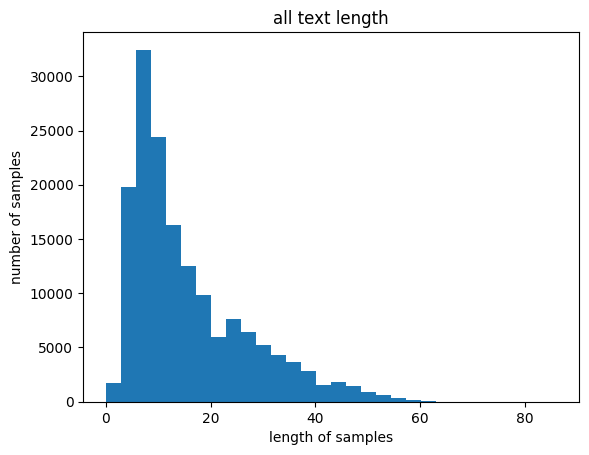

In [33]:
import matplotlib.pyplot as plt

num_tokens = [len(review) for review in X_train]

plt.title('all text length')
plt.hist(num_tokens, bins=30) #데이터 길이 분포
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [34]:
select_length = 40

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1

    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(select_length, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9564986306166602


In [35]:
# 최대 길이를 40으로 잡고 패딩
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [36]:
# model 변경 함수
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params) #모델 인스턴스 생성하여 반환

In [39]:
len(X_train)

159926

In [40]:
len(X_test)

39982

### DataLoader 생성

In [37]:
from torch.utils.data import Dataset, DataLoader

class LabeledNumpyArrayDataset(Dataset):
    def __init__(self, numpy_data, numpy_labels, transform=None):
        self.data = numpy_data
        self.labels = numpy_labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [38]:
batch_size = 64

# 레이블링된 데이터셋 객체 생성
train_dataset = LabeledNumpyArrayDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = LabeledNumpyArrayDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [42]:
x, y = next(iter(train_dataloader))
print(x.shape)
print(y.shape)

torch.Size([64, 40])
torch.Size([64])


In [46]:
x

tensor([[   0,    0,    0,  ...,  545,    8, 3098],
        [   0,    0,    0,  ...,  702, 1602,  273],
        [   0,    0,    0,  ..., 7938, 4401,  168],
        ...,
        [   0,    0,    0,  ...,    9,  123,    5],
        [   0,    0,    0,  ...,   65,  111,  358],
        [   0,    0,    0,  ...,    2,    5,    3]], dtype=torch.int32)

In [47]:
y

tensor([1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1])

### 모델 학습 (Vanilla RNN)

In [43]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(RNNModel, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim) #단어 집합의 크기가 vocab_size이고 각 단어를 embedding_dim 차원의 임베딩 벡터로 매핑

        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        #.requires_grad_() : 이 텐서를 기울기를 계산해야 하는 변수로 지정
        h0 = h0.to(self.device)
        out, h0 = self.rnn(embedded, h0.detach())
        #어차피 h0.detach() 설정하여 그래디언트 계산 중지한다면..
        #처음에 왜 requires_grad_() 한건지??

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        # 가장 마지막 output 선택
        out = out[:, -1, :] # 64 x 64 size

        """
        문제1: 이제 out을 우리가 원하는 ouput_dim 차원으로 변환해주어야 합니다.
        빈칸에 들어갈 인스턴스 변수를 채워넣어주세요.
        """
        out = self.fc(out)
        return out

**nn.embedding**
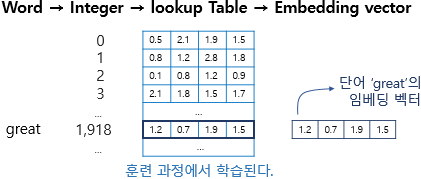

In [44]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [49]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)



        """
        문제2: loss를 구하기 위해서 위에서 정의한 변수 중 무엇을 사용하면 될까요? 빈칸을 채워넣어주세요.
        """
        loss = criterion(logits, labels)

        loss.backward()

        """
        문제3: 역전파를 거친 후 매개변수(가중치)를 업데이트하기 위해서 필요한 메서드는 무엇이었나요?
        빈칸을 채워넣어주세요.
        """
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.20847074687480927. Accuracy: 88.169677734375
Iteration: 1000. Loss: 0.20165172219276428. Accuracy: 87.65694427490234
Iteration: 1500. Loss: 0.2251133769750595. Accuracy: 88.14216613769531
Iteration: 2000. Loss: 0.2152765393257141. Accuracy: 88.22720336914062
Iteration: 2500. Loss: 0.2377128154039383. Accuracy: 88.46231079101562
Iteration: 3000. Loss: 0.26740187406539917. Accuracy: 88.31724548339844
Iteration: 3500. Loss: 0.20263995230197906. Accuracy: 87.94707489013672
Iteration: 4000. Loss: 0.37734198570251465. Accuracy: 87.96708679199219
Iteration: 4500. Loss: 0.2162439227104187. Accuracy: 87.9795913696289
Iteration: 5000. Loss: 0.2566618323326111. Accuracy: 88.18468475341797
Iteration: 5500. Loss: 0.26671701669692993. Accuracy: 88.36226654052734
Iteration: 6000. Loss: 0.23056435585021973. Accuracy: 88.42729187011719
Iteration: 6500. Loss: 0.2864078879356384. Accuracy: 87.78950500488281
Iteration: 7000. Loss: 0.25202497839927673. Accuracy: 87.8995590209961
Ite

### 모델학습 (LSTM, Long short term memory)

In [51]:
class LSTMModel(nn.Module):

    def __init__(self,vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(LSTMModel, self).__init__()

        self.device = device

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # 초기에 cell state를 영행렬로 초기화
        c0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        c0 = c0.to(self.device)

        out, (hn, cn) = self.lstm(embedded, (h0.detach(), c0.detach()))

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :]

        # fc layer를 통해 (batch_size, output_dim)로 차원을 변경해줍니다.
        out = self.fc(out)

        return out

In [52]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4 #2?

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [53]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.15838727355003357. Accuracy: 90.31564331054688
Iteration: 2000. Loss: 0.23593564331531525. Accuracy: 91.22354888916016
Iteration: 3000. Loss: 0.21899352967739105. Accuracy: 91.39112854003906
Iteration: 4000. Loss: 0.18348872661590576. Accuracy: 91.53118896484375
Iteration: 5000. Loss: 0.10562261939048767. Accuracy: 91.54119110107422
Iteration: 6000. Loss: 0.11862608790397644. Accuracy: 91.49617767333984
Iteration: 7000. Loss: 0.0966348648071289. Accuracy: 91.43114471435547
Iteration: 8000. Loss: 0.1370687633752823. Accuracy: 91.27857971191406
Iteration: 9000. Loss: 0.1325879991054535. Accuracy: 91.26107025146484
Iteration: 10000. Loss: 0.17780989408493042. Accuracy: 91.08599090576172
Iteration: 11000. Loss: 0.21121563017368317. Accuracy: 90.96593475341797
Iteration: 12000. Loss: 0.1261020451784134. Accuracy: 90.98094177246094
Iteration: 13000. Loss: 0.056481584906578064. Accuracy: 90.93341827392578
Iteration: 14000. Loss: 0.1327892392873764. Accuracy: 90.993446

label이 0, 1뿐이면 **output_dim**을 **2**로 설정하는게 맞지 않나..?   
or **output_dim = 1** & **nn.BCEWithLogitsLoss()**

In [66]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 2

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

In [67]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.1879459023475647. Accuracy: 90.13056182861328
Iteration: 2000. Loss: 0.1423189491033554. Accuracy: 91.19603729248047
Iteration: 3000. Loss: 0.3947441279888153. Accuracy: 91.23855590820312
Iteration: 4000. Loss: 0.16750533878803253. Accuracy: 91.50117492675781
Iteration: 5000. Loss: 0.1264519989490509. Accuracy: 91.47116088867188
Iteration: 6000. Loss: 0.2065981924533844. Accuracy: 91.42613983154297
Iteration: 7000. Loss: 0.2191588431596756. Accuracy: 91.4111328125
Iteration: 8000. Loss: 0.248113751411438. Accuracy: 91.20854187011719
Iteration: 9000. Loss: 0.26823821663856506. Accuracy: 91.04096984863281
Iteration: 10000. Loss: 0.09668954461812973. Accuracy: 91.26856994628906
Iteration: 11000. Loss: 0.04609474539756775. Accuracy: 91.09849548339844
Iteration: 12000. Loss: 0.16489103436470032. Accuracy: 90.92341613769531
Iteration: 13000. Loss: 0.0997127965092659. Accuracy: 91.01596069335938
Iteration: 14000. Loss: 0.03291650861501694. Accuracy: 90.7158203125
Iter

### 모델 학습 (Gated Recurrent Unit (GRU))

In [68]:
class GRUModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layers
        self.gru = nn.GRU(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):

        embedded = self.embedding(text)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(embedded, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out


In [69]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

In [70]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.29596734046936035. Accuracy: 90.49322509765625
Iteration: 2000. Loss: 0.2221606969833374. Accuracy: 91.08849334716797
Iteration: 3000. Loss: 0.1845347285270691. Accuracy: 91.3711166381836
Iteration: 4000. Loss: 0.11902143806219101. Accuracy: 91.02596282958984
Iteration: 5000. Loss: 0.23776155710220337. Accuracy: 91.28107452392578
Iteration: 6000. Loss: 0.03446044772863388. Accuracy: 91.36361694335938
Iteration: 7000. Loss: 0.19462139904499054. Accuracy: 91.10599517822266
Iteration: 8000. Loss: 0.14771480858325958. Accuracy: 90.85338592529297
Iteration: 9000. Loss: 0.182330921292305. Accuracy: 91.10099792480469
Iteration: 10000. Loss: 0.14506076276302338. Accuracy: 90.88089752197266
Iteration: 11000. Loss: 0.0778849869966507. Accuracy: 90.54574584960938
Iteration: 12000. Loss: 0.17788353562355042. Accuracy: 90.9109115600586
Iteration: 13000. Loss: 0.24977344274520874. Accuracy: 90.78585815429688
Iteration: 14000. Loss: 0.1578587293624878. Accuracy: 90.6482925415

## 모델 성능 비교

옵티마이저, 파라미터 등을 바꿔가며 모델의 성능을 향상시켜보세요.

이후 세 가지 모델의 성능 차이를 비교하고, 자유롭게 해석해보세요!

test accuracy 기준으로 비교했을 때, RNN의 성능이 가장 낮고 LSTM과 GRU의 성능은 비슷함. LSTM, GRU는 게이트 메커니즘을 사용하여 장기 의존성을 더 잘 학습할 수 있기 때문에 더 나은 성능을 보였을 것. (데이터가 장기 의존성이 중요한 경우)